In [1]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 3: Multiple Major Occupations

We now allow for a more flexible occupation-sector structure, using occupation-by-sector employment data from [NEED TO FILL IN].  

In [2]:
A_spec = 1
data_dir = '../data/clean/'
dfTau = pd.read_csv(data_dir + 'tau_2021.csv').sort_values(by=['short_names'])
dfepsN = pd.read_csv(data_dir + 'epsN_2021.csv', index_col=0).sort_index(axis=1)
dfcurlyL =  pd.read_csv(data_dir + 'curlyL_2021.csv', index_col=0).sort_index()
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors = dfA['short_names']
dfDemand  = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'short_names'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]

# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
curlyL = np.array(dfcurlyL)

J = Omega.shape[0]
O = dfcurlyL.shape[0]

# this is sector-level, need to change
epsN = np.array((np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64') * dfepsN.T).T)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))


#if you want to turn of network linkages turn on these two lines of code.
#Omega = np.zeros_like(Omega)
#Psi = np.eye(Omega.shape[0])
θ = dfLabor_market_yearly['Tightness'] 
ν = np.ones(O) * 0.5
curlyQ = np.diag(-ν)
curlyF =  np.eye(O) + curlyQ
#r = 0.0293
tau = np.matrix(dfcurlyL) @  np.matrix(dfTau['Tau']).reshape((13, 1))
tau = np.array([tau[i, 0] for i in range(tau.shape[0])])
curlyT = np.diag(tau)
#curlyT = np.diag(r / (np.mean(φ)*np.mean(θ)**(-ν) - r))
# NOTE: here I am picking the r so the τ's roughly look right. Down the line, we can calibrate τ directly from the data. 
# Also note that tightness is computed from unemployed workers, but in our model it should be computed from the whole work force.

First, we define the shocks we are interested in to allow us to easily change these in the future, that is we define the vectors $d\log\bm{A}$ and $d\log\bm{H}$.

In [3]:
dlog_A = np.zeros((J, 1))
#dlog_A = 0.01 * np.ones_like(dlog_A) 
dlog_A[3] = 0.01
dlog_H = np.zeros((O,1))

We assume Cobb-Douglas production and preferences.

In [4]:
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)

Finally, we need to make some assumption about how wages change. We begin by assuming that nominal wages do not change in respond to changes in either productivity or the labor force.

In [5]:
#epsW_A = np.zeros((O,J))
gamma_A = 1
gamma_H = 1
epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, Psi, curlyL, epsN)
epsW_A

array([[0.05384902, 0.04903093, 0.15480407, 0.21208788, 0.29593888,
        0.09366319, 0.08244988, 0.03597753, 0.14543616, 0.04392311,
        0.39520285, 0.12902608, 0.13256326],
       [0.04194345, 0.01679547, 0.18318027, 0.04565279, 0.14566645,
        0.14155665, 0.06324201, 0.06205594, 0.35679778, 0.03178552,
        0.3455919 , 0.44939789, 0.06506092],
       [0.11059619, 0.01316815, 0.13015701, 0.15649658, 0.16131817,
        0.04817895, 0.31936012, 0.02863413, 0.13850486, 0.05798484,
        0.47418916, 0.13732961, 0.04315075],
       [0.039621  , 0.05819225, 0.17505798, 0.09205625, 0.36492486,
        0.13262057, 0.10020664, 0.03152424, 0.12769261, 0.0445765 ,
        0.52437865, 0.06454051, 0.04426201],
       [0.28215856, 0.00953285, 0.10256362, 0.29588261, 0.17239626,
        0.08021249, 0.07575937, 0.02951315, 0.13381804, 0.3133087 ,
        0.22411679, 0.0359545 , 0.04195869],
       [0.17442275, 0.0170825 , 0.09945563, 0.21223826, 0.17972316,
        0.05813575, 0.07292

In [6]:
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)

With these pieces in hand, we can now estimate responses to tightness. For details, see the multiple occupations example code.

In [7]:
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
dlog_theta

array([[ 0.00000000e+00],
       [-5.55111512e-17],
       [ 0.00000000e+00],
       [ 1.11022302e-16],
       [ 1.11022302e-16],
       [ 1.11022302e-16],
       [ 5.55111512e-17],
       [-1.11022302e-16],
       [-1.66533454e-16],
       [ 1.66533454e-16],
       [-2.77555756e-16],
       [-1.11022302e-16],
       [ 0.00000000e+00],
       [ 5.55111512e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-5.55111512e-17],
       [ 0.00000000e+00],
       [ 1.66533454e-16],
       [ 0.00000000e+00],
       [-5.55111512e-17],
       [ 0.00000000e+00]])

In [8]:
num=0
dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_wR, dlog_theta, Psi, curlyQ, epsN, curlyT, curlyL, num=num)
dlog_p

array([[ 0.00000000e+00],
       [ 3.64454735e-05],
       [ 3.66548911e-05],
       [-1.01159058e-02],
       [ 3.56231649e-05],
       [-7.25291428e-05],
       [ 3.38251115e-05],
       [ 3.66533927e-05],
       [ 3.59495415e-05],
       [-6.21365077e-05],
       [ 2.92041074e-05],
       [ 1.16776584e-05],
       [ 3.08696046e-05]])

In [9]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
dlog_y

array([[3.92196827e-05],
       [2.77420919e-06],
       [2.56479167e-06],
       [1.01551255e-02],
       [3.59651787e-06],
       [1.11748826e-04],
       [5.39457123e-06],
       [2.56629006e-06],
       [3.27014124e-06],
       [1.01356190e-04],
       [1.00155754e-05],
       [2.75420243e-05],
       [8.35007816e-06]])

We can check labor market clearing holds.

In [10]:
multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF) - multi_occupation_network.LaborDemand(dlog_wR, dlog_y, dlog_p, dlog_epsN, curlyL)

array([[-6.50521303e-18],
       [-4.25549353e-17],
       [-1.12757026e-17],
       [ 4.33680869e-17],
       [ 4.64038530e-17],
       [ 4.68375339e-17],
       [ 1.36609474e-17],
       [-2.77555756e-17],
       [-9.29025737e-17],
       [ 4.99817202e-17],
       [-1.14491749e-16],
       [-2.60208521e-17],
       [-1.12214925e-17],
       [ 1.82145965e-17],
       [-1.18178037e-17],
       [-9.37834879e-18],
       [-3.23092247e-17],
       [-1.43114687e-17],
       [ 5.95226993e-17],
       [-4.33680869e-19],
       [-7.80625564e-18],
       [-1.41488384e-17]])

Aggregate output changes are.

In [11]:
dlog_aggY = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_aggY

array([[0.00133044]])

Since labor market frictions are the only source of inefficiency in our network economy, in the absence of labor market frictions our network economy is fully efficient. It is well known that Hulten's theorem holds in efficient network economies with Cobb-Douglas technology. We can therefore easily compare the implications of labor market frictions for aggregate output with the implications of the same technology shocks absent labor market frictions.  

In [12]:
epsD.T @ Psi @ dlog_A

array([[0.00133044]])

## Calibration figures: Response to Technology Shock

### Aggregate importance of deviations from Hulten.

To analyse the quantitative importance of deviations from Hulten's theorem, below we vary $\gamma_A$ from 0 to 2, and plot the aggregate response to a 1\% shock to durable goods.

In [13]:
# Setting which sectors to shock, and getting the full name of the sector. 
sec_to_shock = 'dur'
# For reference, these are other sectors we can shock
print(sectors)
sec_dict = pd.read_excel("../data/update_raw/long_short_names_crosswalk.xlsx")
sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
print(f'the full name for {sec_to_shock} is {sec_full}')

0        accom
1        const
2          dur
3     edhealth
4          fin
5          gov
6         info
7       mining
8       nondur
9        other
10    profserv
11       trade
12       trans
Name: short_names, dtype: object
the full name for dur is Durable Goods Manufacturing


In [14]:
N=1000
gamma_a_vec = np.linspace(0,2,N)
aggY_vec = np.zeros_like(gamma_a_vec)
dlog_A = np.zeros((J, 1))
#dlog_A = 0.01 * np.ones_like(dlog_A)
dlog_A[np.where(sectors == 'dur')] = 0.01 
dlog_H = np.zeros((O,1))
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)


for i in range(N):
    epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_a_vec[i], 1, Psi, curlyL, epsN)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
    aggY_vec[i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)

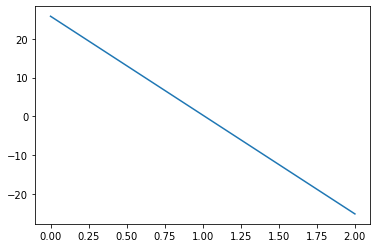

In [15]:
plt.plot(gamma_a_vec,100*aggY_vec)

Next, we plot responses of sectoral output to technology shocks assuming $\gamma_A = [0.9, 1, 1.1]$. 

In [16]:
gamma_A_vec = np.array([0.95,1,1.05])
sectorY_vec = np.zeros((J+1,gamma_A_vec.shape[0]))
occT_vec = np.zeros((O,gamma_A_vec.shape[0]))
occU_vec = np.zeros((O,gamma_A_vec.shape[0]))
for i in range(gamma_A_vec.shape[0]):
    epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_A_vec[i], 1, Psi, curlyL, epsN)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
    occT_vec[:, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    occU_vec[:,i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [17]:
occU_vec

array([[-1.27896977e-02,  0.00000000e+00,  1.27896977e-02],
       [-1.28253483e-02,  5.55111512e-17,  1.28253483e-02],
       [-1.27683757e-02, -5.55111512e-17,  1.27683757e-02],
       [-1.27967412e-02,  0.00000000e+00,  1.27967412e-02],
       [-1.27583082e-02,  0.00000000e+00,  1.27583082e-02],
       [-1.27506688e-02,  0.00000000e+00,  1.27506688e-02],
       [-1.30289998e-02, -5.55111512e-17,  1.30289998e-02],
       [-1.27311448e-02,  0.00000000e+00,  1.27311448e-02],
       [-1.30125230e-02,  0.00000000e+00,  1.30125230e-02],
       [-1.27589190e-02, -1.11022302e-16,  1.27589190e-02],
       [-1.27342669e-02, -5.55111512e-17,  1.27342669e-02],
       [-1.27313537e-02,  0.00000000e+00,  1.27313537e-02],
       [-1.27443927e-02,  0.00000000e+00,  1.27443927e-02],
       [-1.28182349e-02, -5.55111512e-17,  1.28182349e-02],
       [-1.27874207e-02, -5.55111512e-17,  1.27874207e-02],
       [-1.32166523e-02, -5.55111512e-17,  1.32166523e-02],
       [-1.27577554e-02, -1.11022302e-16

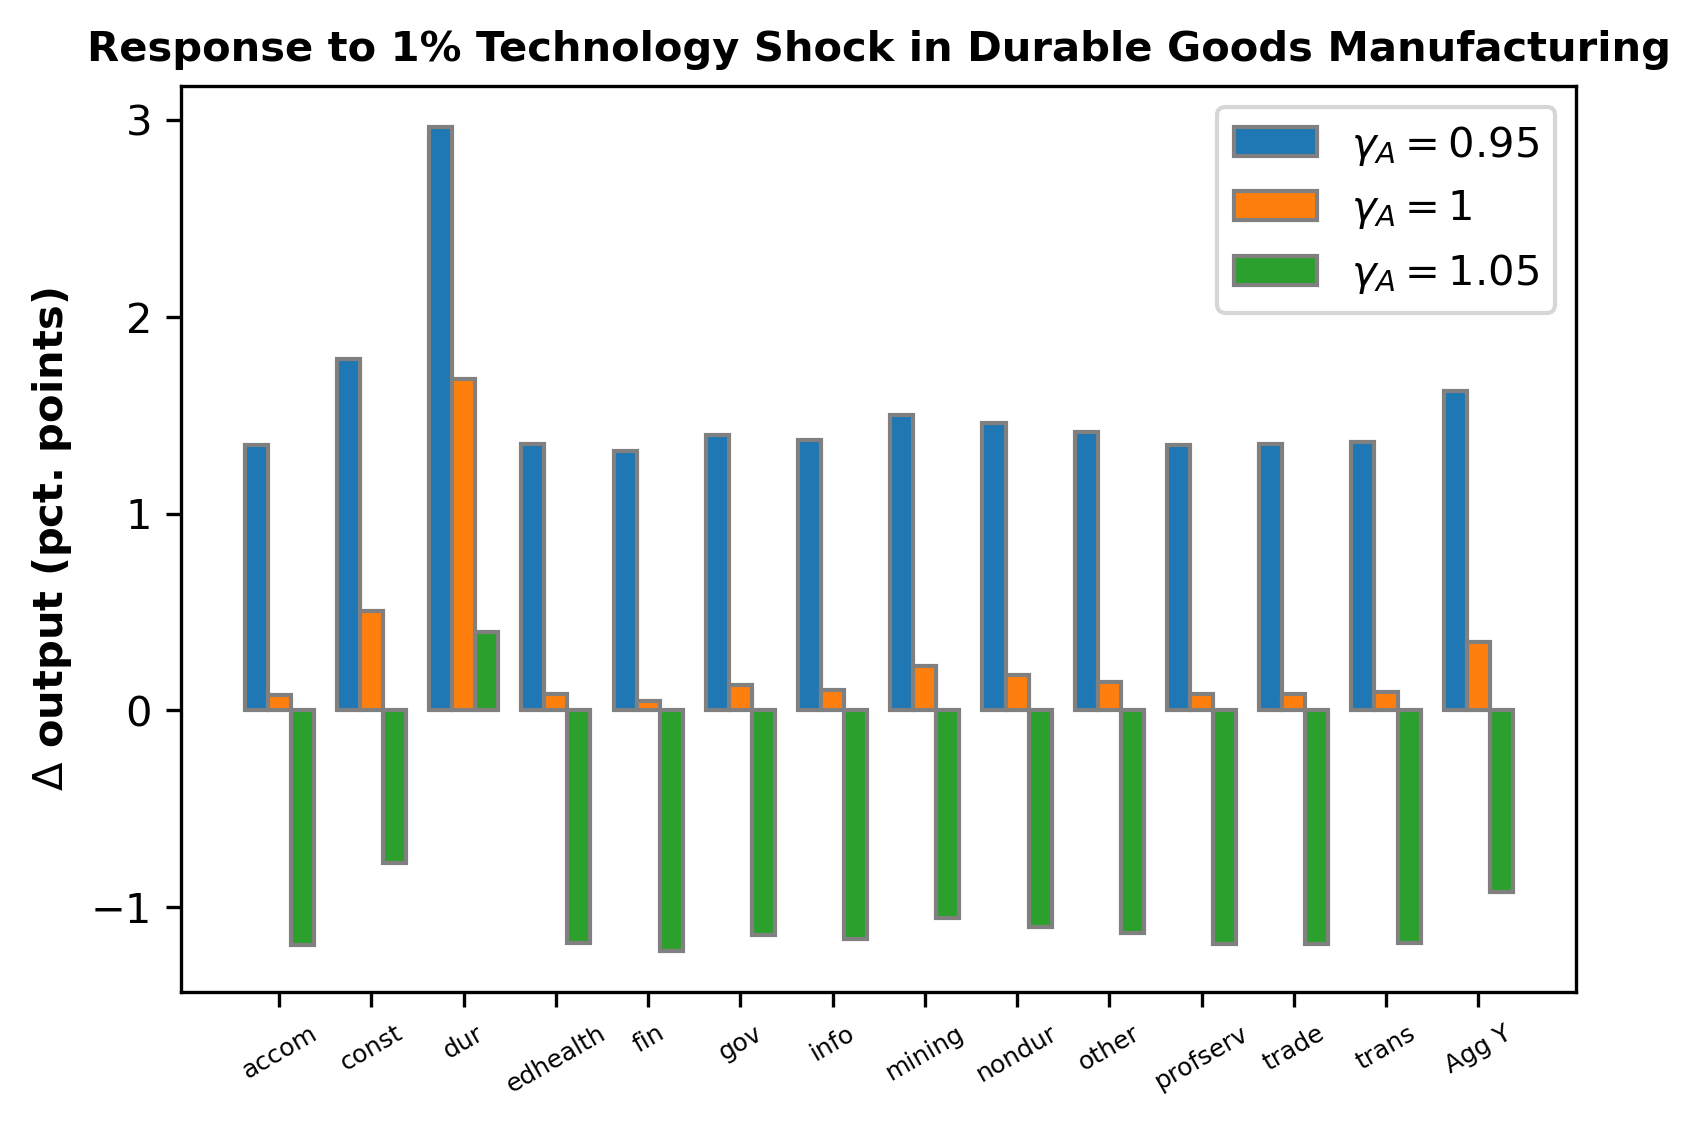

In [18]:
sector_names = list(sectors) + ['Agg Y']
title = f'Response to 1% Technology Shock in {sec_full}'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockY_calib3.png'
labels = ['$\gamma_{A} = 0.95$','$\gamma_{A} = 1$', '$\gamma_{A} = 1.05$']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

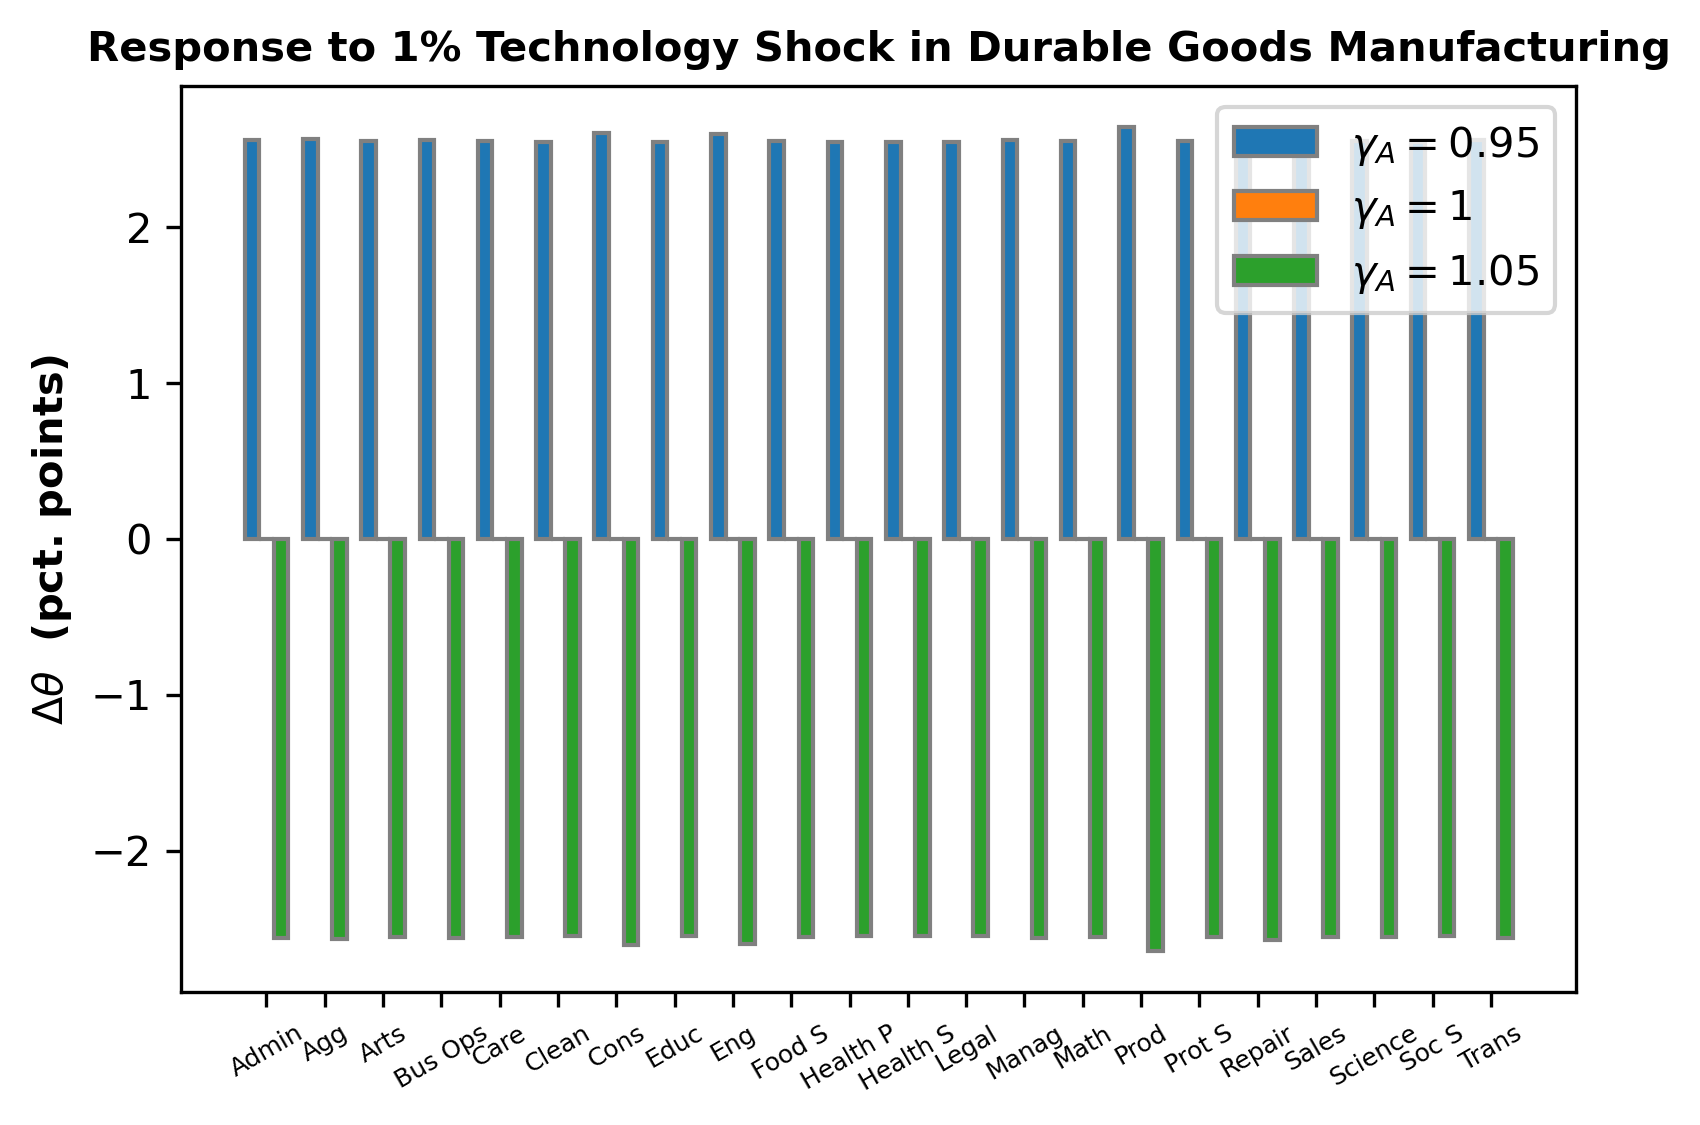

In [24]:
occupation_names = dfcurlyL.index
xlab = ''
ylab = '$\Delta \\theta$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockT_calib3.png'
labels = ['$\gamma_{A} = 0.95$','$\gamma_{A} = 1$', '$\gamma_{A} = 1.05$']
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

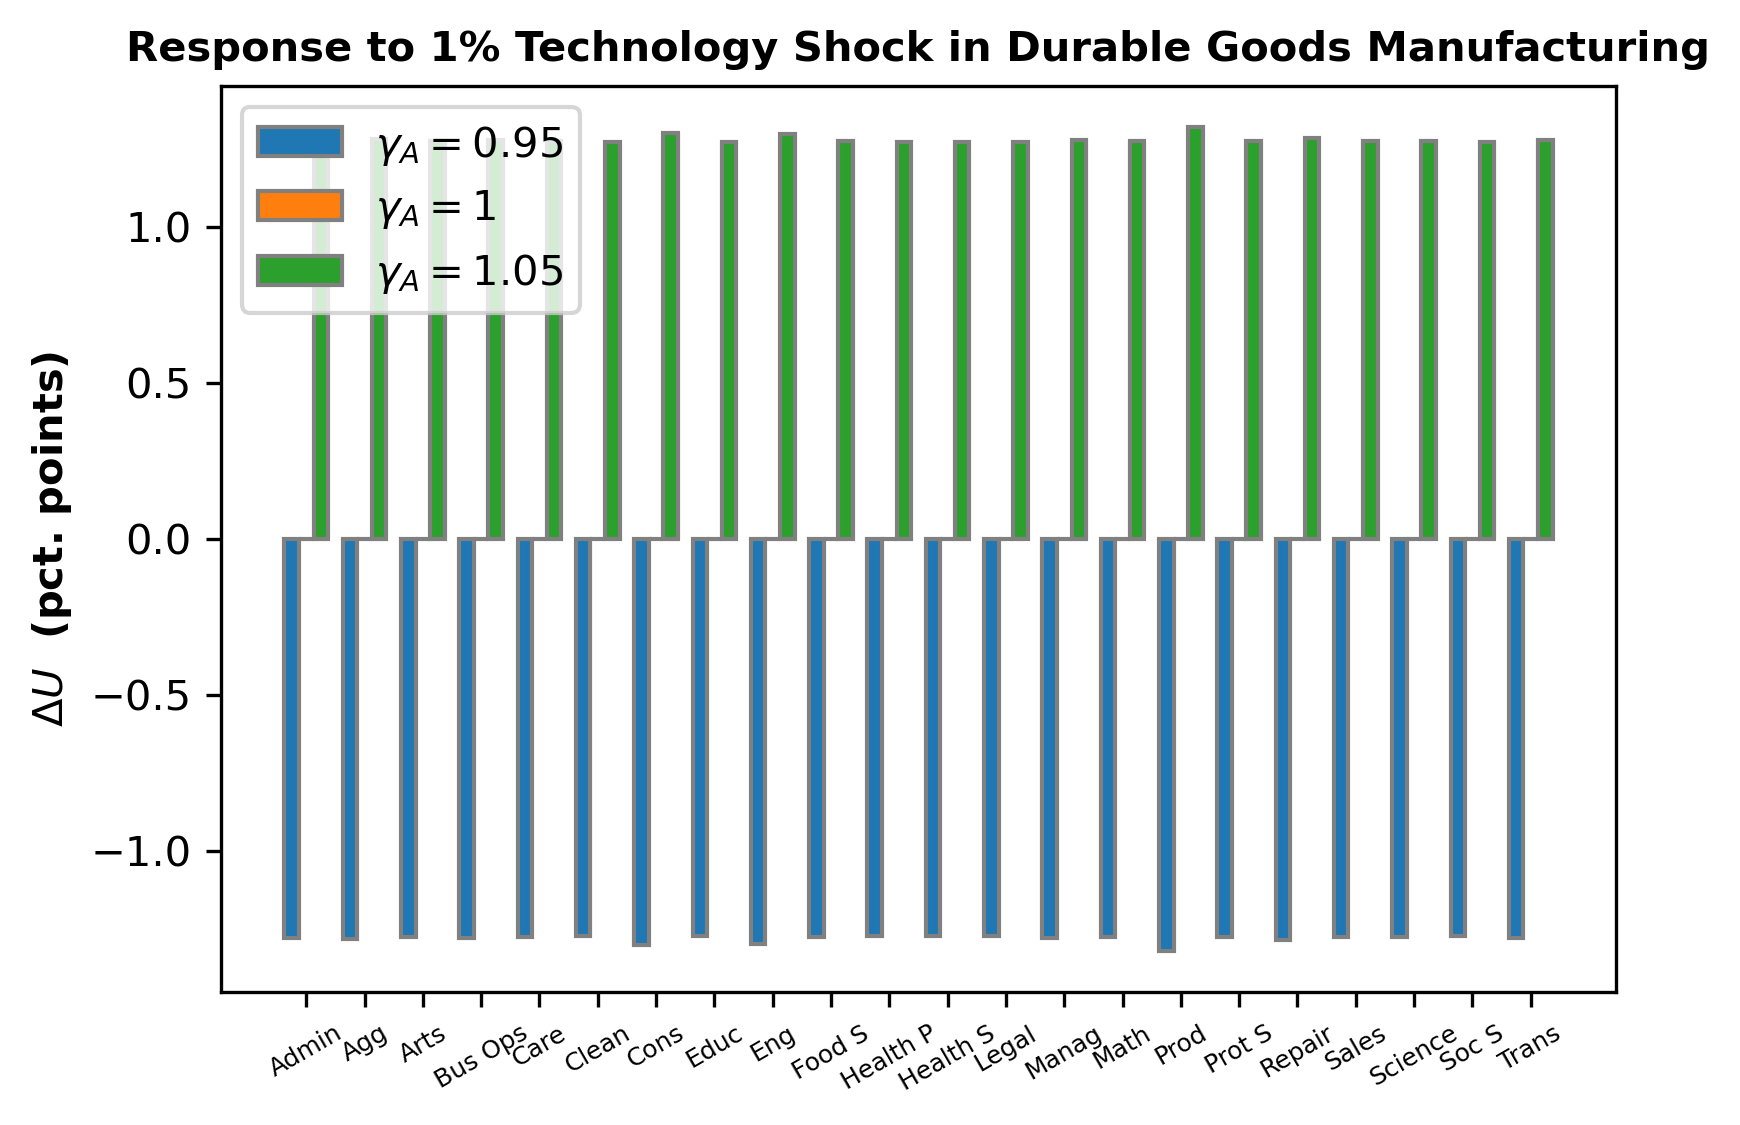

In [26]:
xlab = ''
ylab = '$\Delta U$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockU_calib3.png'
labels = ['$\gamma_{A} = 0.95$','$\gamma_{A} = 1$', '$\gamma_{A} = 1.05$']
bar_plot(100*occU_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

## Calibration Figures: Response to Labor Force Shock
We repeat the code above for the case of a shock to the size of the labor force, $d\log\bm{H}$.

In [ ]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O,1))
dlog_H[3] = 0.01 
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)

In [ ]:
gamma_H_vec = np.array([0.95,1,1.05])
sectorY_vec = np.zeros((J+1,3))
occT_vec = np.zeros((O,3))
occU_vec = np.zeros((O,3))
for i in range(3):
    epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(1, gamma_H_vec[i], Psi, curlyL, epsN)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
    occT_vec[:, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    occU_vec[:,i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [ ]:
title = f'Response to 1% Labor force Shock in {sec_full}'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_HshockY_calib3.png'
labels = ['$\gamma_{H} = 0.95$','$\gamma_{H} = 1$','$\gamma_{H} = 1.05$']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

In [ ]:
occupation_names = dfcurlyL.index
xlab = ''
ylab = '$\Delta \\theta$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_HshockT_calib3.png'
labels = ['$\gamma_{H} = 0.95$','$\gamma_{H} = 1$','$\gamma_{H} = 1.05$']
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

In [ ]:
xlab = ''
ylab = '$\Delta U$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_HshockU_calib3.png'
labels = ['$\gamma_{H} = 0.95$','$\gamma_{H} = 1$','$\gamma_{H} = 1.05$']
bar_plot(100*occU_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

## Response to mean preserving shock to productivity
The effect of shocks to technology on aggreggate output is given by
\begin{align*}
    d\log Y = {\varepsilon^{\mathcal{D}}_c}'\left(\bm{I} + \bm{\varepsilon^f_N}\left(\bm{\mathcal{F}}+\bm{\mathcal{QT}}\right)\left(\bm{\mathcal{F}}-\bm{\Xi_{\theta}}\right)^{-1}\left(\bm{\mathcal{L}\Psi}-\bm{\Lambda_A}\right)\right)d\log\bm{A}
\end{align*}
We are looking for shocks such that $d\log Y = 0$.

In [ ]:
def MeanPresObj(dlog_A, Psi, epsN, epsD, curlyL, curlyF, curlyQ, curlyT, gamma_A):
    Xi = curlyL @ Psi @ epsN @ (curlyF + curlyQ @ curlyT)
    Pi_y = Psi @ (np.eye(J) + (1-gamma_A) * epsN @ (curlyF + curlyQ @ curlyT) @ np.linalg.inv(np.eye(Xi.shape[0])-Xi) @ curlyL @ Psi)
    Pi_Y = epsD.T @ Pi_y
    return Pi_Y @ dlog_A

In [ ]:
gamma_A = 0.95
dlog_H = np.zeros_like(dlog_H)
dlog_A = 0.02*np.ones_like(dlog_A)
dlog_A[8:] = -0.78717451813079*dlog_A[8:]
MeanPresObj(dlog_A, Psi, epsN, epsD, curlyL, curlyF, curlyQ, curlyT, gamma_A)

In [ ]:
gamma_A = 0
dlog_H = np.zeros_like(dlog_H)
dlog_A = 0.02*np.ones_like(dlog_A)
dlog_A[8:] = -0.78692359906576855*dlog_A[8:]
MeanPresObj(dlog_A, Psi, epsN, epsD, curlyL, curlyF, curlyQ, curlyT, gamma_A)

In [ ]:
epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_A, 1, Psi, curlyL, epsN)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
dlog_Y = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [ ]:
title = f'Response to 1% Technology Shock in {sec_full}'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_AshockY_meanpres.png'
labels = ['$\gamma_{A} = 0.95$']
bar_plot(100*np.append(dlog_y, dlog_Y).reshape((J+1,1)), sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

In [ ]:
xlab = ''
ylab = '$\Delta U$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_HshockU_meanpres.png'
labels = ['$\gamma_{H} = 0.95$']
bar_plot(100*dlog_U.reshape((O,1)), occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

In [ ]:
dlog_U